In [224]:
# !pip install prophet

# TIME SERIES ANALYSIS

In [222]:
# !pip install --upgrade scipy statsmodels


In [231]:
import prophet
prophet.__version__

'1.1.5'

##  Importing libraries

In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime, timedelta
register_matplotlib_converters()
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [243]:
from sklearn.metrics import mean_absolute_error
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose

In [242]:
import statsmodels
print("Statsmodels version:", statsmodels.__version__)

Statsmodels version: 0.14.1


## About Dataset

PJM Interconnection LLC (PJM) operates as a regional transmission organization (RTO) within the United States, specifically managing the electric transmission system across a portion of the Eastern Interconnection grid. This area includes regions of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The dataset provided encompasses over a decade's worth of hourly energy consumption data from PJM, measured in Megawatts.

This notebook will explore a model solution for univariate time series analysis. While numerous models exist for time series forecasting, one widely-used approach is Prophet, developed by Facebook/Meta. 


In [13]:
df = pd.read_csv(r"C:\Users\91971\Time-Series-Analysis-master\PJME_hourly.csv", index_col='Datetime')


In [39]:
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


### Each dataset info

PJME_hourly.csv: This dataset contains hourly electricity consumption data from the PJM Interconnection LLC (PJM), which is a regional transmission organization (RTO) operating an electric transmission system serving several states in the eastern United States.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2+ MB


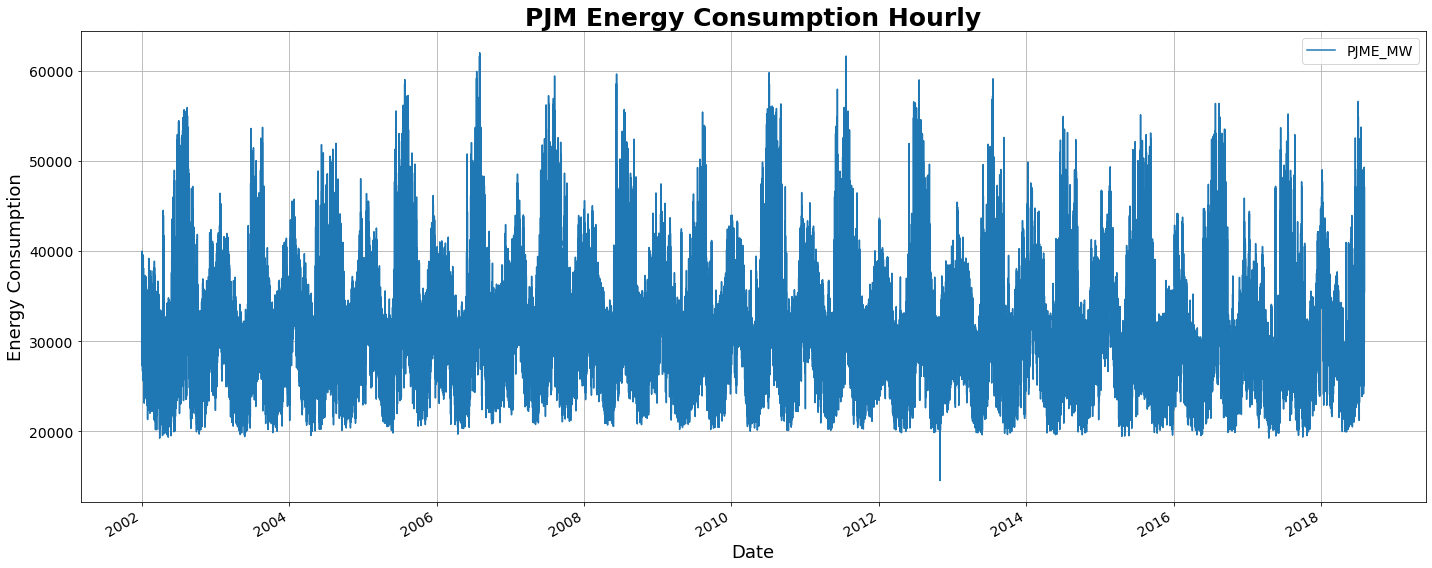

In [226]:
# Convert index to datetime
df.index = pd.to_datetime(df.index)


fig, ax = plt.subplots(figsize=(20, 8))

# Plot the dataframe
df.plot(ax=ax)
plt.title('PJM Energy Consumption Hourly', weight='bold', fontsize=25)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Energy Consumption', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.legend(fontsize=14)
plt.tight_layout()  
plt.show()

# Checking if Data is Stationary or Not?
## Augmented Dickey-Fuller Test

In [19]:
from statsmodels.tsa.stattools import adfuller

In [22]:
# Extract the PJME hourly consumption data
pjme_data = df['PJME_MW']

# Perform the ADF Test
result = adfuller(pjme_data)


In [24]:
adf_statistic_decimal = "{:.5f}".format(result[0])

p_value_decimal = "{:.5f}".format(result[1])


print('ADF Statistic:', adf_statistic_decimal)
print('p-value:', p_value_decimal)


ADF Statistic: -18.82891
p-value: 0.00000


- The null hypothesis of the ADF Test is that the time series is non-stationary. 

- If the p-value is less than a significance level (e.g., 0.05), you can reject the null hypothesis and conclude that the time series is stationary.

- If the p-value is greater than the significance level, you fail to reject the null hypothesis, indicating that the time series is non-stationary.

- ### **Hence, This is Stationary. We can do time series analysis on this.**

# 1. SARIMA MODEL (Seasonal ARIMA)

https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/
- The SARIMA (Seasonal Autoregressive Integrated Moving Average) model is a widely used time series forecasting method that extends the ARIMA model to account for seasonality in the data. 

### MONTHLY ANALYSIS

In [51]:
# Resample the data to monthly frequency and sum the values for each month
df_monthly = df.resample('M').sum()
print("**FOR LOOKING AT SEASONAL PATTERN**")
print(df_monthly)



**FOR LOOKING AT SEASONAL PATTERN**
               PJME_MW
Datetime              
2002-01-31  23089022.0
2002-02-28  20320720.0
2002-03-31  21483191.0
2002-04-30  20516472.0
2002-05-31  20886798.0
...                ...
2018-04-30  19694352.0
2018-05-31  21278364.0
2018-06-30  23050418.0
2018-07-31  27302373.0
2018-08-31   1927258.0

[200 rows x 1 columns]


In [41]:
# Resample the data to weekly frequency and sum the values for each week
df_weekly = df.resample('W').sum()

print(df_weekly)

              PJME_MW
Datetime             
2002-01-06  4632079.0
2002-01-13  5289881.0
2002-01-20  5284084.0
2002-01-27  5063777.0
2002-02-03  4905010.0
...               ...
2018-07-08  6461277.0
2018-07-15  6118566.0
2018-07-22  5982832.0
2018-07-29  6145746.0
2018-08-05  3547174.0

[866 rows x 1 columns]


## ACF (Autocorrelation Function)
https://www.youtube.com/watch?v=DeORzP0go5I

<BarContainer object of 15 artists>

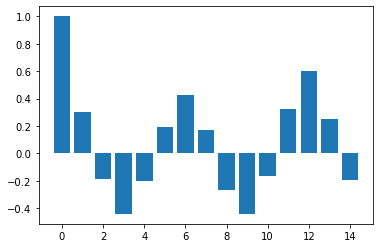

In [46]:
acf_vals = acf(df_monthly)
num_lags = 15
plt.bar(range(num_lags), acf_vals[:num_lags])

 - seasonal MA process of every 6 months

## PACF (Partial Autocorrelation Function)

<BarContainer object of 15 artists>

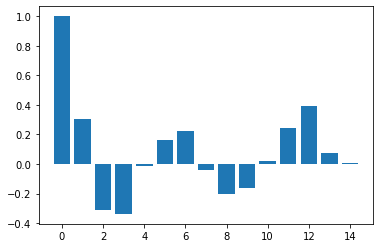

In [47]:
pacf_vals = pacf(df_monthly)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])

- Seasonal pattern after every 6 month can be witnessed. electricity being consumed in winter and summer are greater.

In [49]:
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


## TRAINING AND TESTING DATA

In [149]:
from dateutil.relativedelta import relativedelta




In [150]:
train_end = datetime(2017,1,2)
test_end = datetime(2018,1,3)

train_data = df_monthly[:train_end]
test_data = df_monthly[train_end + relativedelta(months=1):test_end]


In [151]:
import time


In [152]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 6)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [153]:
#fit the model
start = time.time()
model_fit = model.fit()
end = time.time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.11266136169433594


In [154]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                             PJME_MW   No. Observations:                  180
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 6)   Log Likelihood               -2843.346
Date:                             Fri, 03 May 2024   AIC                           5692.691
Time:                                     23:21:14   BIC                           5702.253
Sample:                                 01-31-2002   HQIC                          5696.569
                                      - 12-31-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L6        0.9946      0.016     62.658      0.000       0.963       1.026
ma.S.L6       -0.9465      

In [155]:
# Assuming 'test_data' is your DataFrame
test_series = test_data.iloc[:, 0]

# Display the first few rows of the resulting Series
print(test_series.head())

Datetime
2017-02-28    20358165.0
2017-03-31    22513930.0
2017-04-30    18946410.0
2017-05-31    20075743.0
2017-06-30    23658227.0
Freq: M, Name: PJME_MW, dtype: float64


In [156]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_series - predictions

In [157]:
residuals

Datetime
2017-02-28   -4.731953e+06
2017-03-31   -4.462149e+05
2017-04-30   -2.025698e+06
2017-05-31   -1.605984e+06
2017-06-30   -6.275065e+05
2017-07-31    6.967141e+04
2017-08-31   -6.044313e+05
2017-09-30   -1.799186e+06
2017-10-31   -1.115791e+06
2017-11-30   -1.467468e+06
2017-12-31             NaN
Freq: M, dtype: float64

In [170]:
predictions

Datetime
2017-02-28    2.509012e+07
2017-03-31    2.296014e+07
2017-04-30    2.097211e+07
2017-05-31    2.168173e+07
2017-06-30    2.428573e+07
2017-07-31    2.708210e+07
2017-08-31    2.549898e+07
2017-09-30    2.338056e+07
2017-10-31    2.140331e+07
2017-11-30    2.210908e+07
2017-12-31             NaN
Freq: M, Name: predicted_mean, dtype: float64

Text(0, 0.5, 'Error')

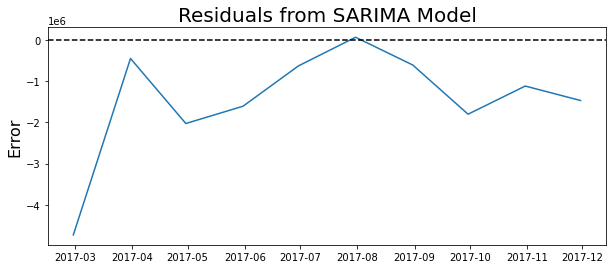

In [159]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

In [176]:
start_date = datetime(2002,1,1)
end_date = datetime(2018,1,2)

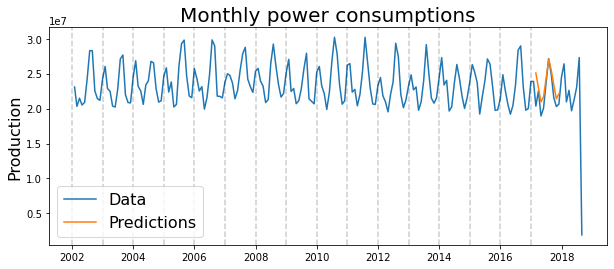

In [177]:
plt.figure(figsize=(10,4))

plt.plot(df_monthly)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Monthly power consumptions', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [162]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_series)),4))

Mean Absolute Percent Error: 0.0702


# 2. FB PROPHET

https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/

In [183]:
def index_to_column(data):
    data = data.reset_index()
    data['Datetime'] = pd.to_datetime(data['Datetime'])
    data = data.sort_values('Datetime')
    
    data = data.rename(columns={'Datetime': 'ds', 'PJME_MW': 'y'})
    return data

In [184]:
prophet_train = index_to_column(train_data)
prophet_test = index_to_column(test_data)

In [185]:
prophet_train

,ds,y
0,2002-01-31,23089022.0
1,2002-02-28,20320720.0
2,2002-03-31,21483191.0
3,2002-04-30,20516472.0
4,2002-05-31,20886798.0
...,...,...
175,2016-08-31,28970495.0
176,2016-09-30,23180224.0
177,2016-10-31,19765631.0
178,2016-11-30,20017379.0


In [186]:
prophet_model = Prophet(interval_width=0.95)

prophet_model.fit(prophet_train)
prophet_pred = prophet_model.predict(prophet_test[['ds']]) # Keep the dataset format

23:38:23 - cmdstanpy - INFO - Chain [1] start processing
23:38:23 - cmdstanpy - INFO - Chain [1] done processing


In [220]:
from matplotlib.ticker import FuncFormatter
# Define a function to format the y-axis labels in millions
def millions_formatter(x, pos):
    return '{:.0f}M'.format(x * 1e-6)

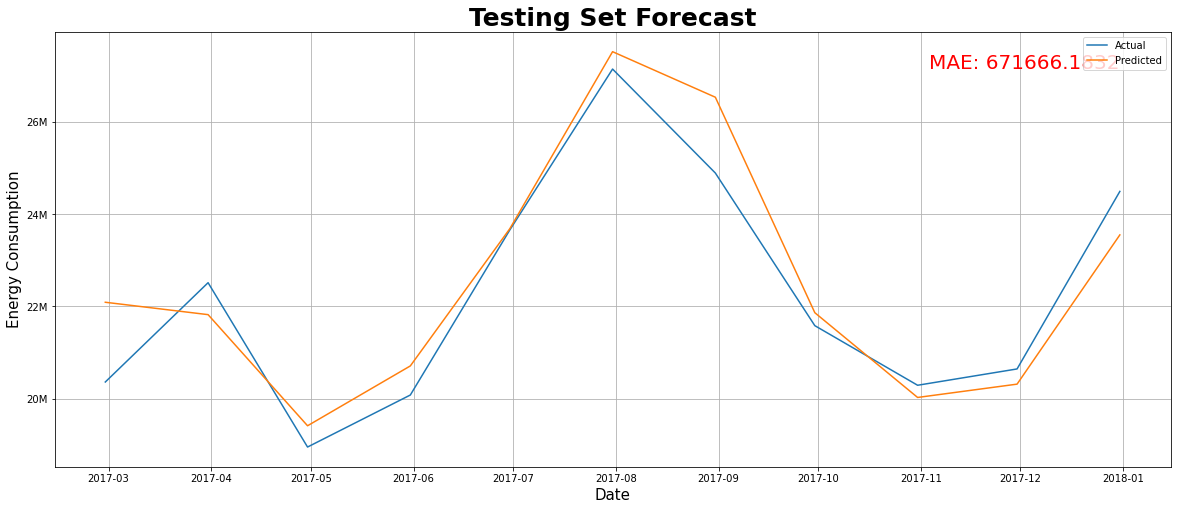

In [221]:
mae = round(mean_absolute_error(prophet_test['y'], prophet_pred['yhat']), 4)

plt.figure(figsize=(20,8))
plt.plot(prophet_test['ds'], prophet_test['y'], label='Actual')
plt.plot(prophet_pred['ds'], prophet_pred['yhat'], label='Predicted')
plt.title('Test Forecasting', weight='bold', fontsize=40)
plt.text(prophet_test['ds'].max(), prophet_test['y'].max(), 'MAE: {}'.format(mae), fontsize=20, color='red', ha='right')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Energy Consumption', fontsize=15)
plt.title('Testing Set Forecast', weight='bold', fontsize=25)
# Get the current axes
ax = plt.gca()

# Set the formatter for the y-axis to millions_formatter
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.legend()
plt.grid(True)
plt.show()


In [196]:
df1 = df.copy()

## Hourly Analysis (FORECAST)

In [228]:
# This time, we will use all data (train and test) to train our model
new_df = index_to_column(df1)


In [199]:
prophet_model2 = Prophet(interval_width=0.95)
prophet_model2.fit(new_df)
# 7 days to the future (7x24 = 168)
future_dates = prophet_model2.make_future_dataframe(periods=168, freq='H')
prophet_pred2 = prophet_model2.predict(future_dates)

23:41:56 - cmdstanpy - INFO - Chain [1] start processing
23:43:51 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1440x576 with 0 Axes>

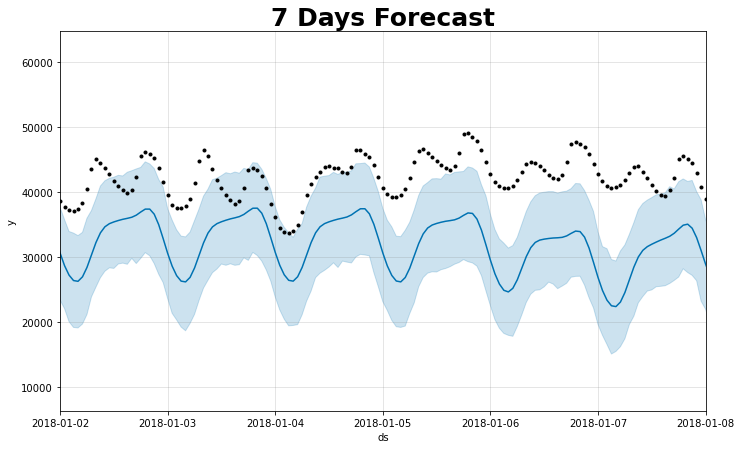

In [207]:
plt.figure(figsize=(20,8))

fig = prophet_model2.plot(prophet_pred2, uncertainty=True)
ax = fig.gca()
ax.set_xlim(pd.to_datetime(['2018-01-02', '2018-01-08']))
plt.title('7 Days Forecast', weight='bold', fontsize=25)
plt.show()

### TIME SERIES ANALYSIS OF A WEEK, DAY, YEAR.

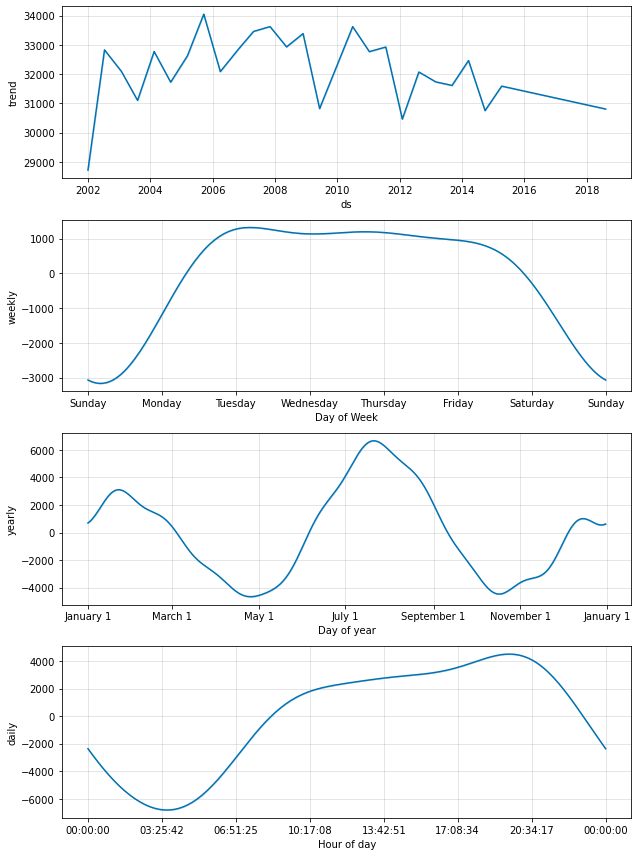

In [229]:
prophet_model2.plot_components(prophet_pred2)
plt.show()

- As summer approaches power consumption increases and is highest in july to august.

In [204]:
df1

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


<Figure size 1440x576 with 0 Axes>

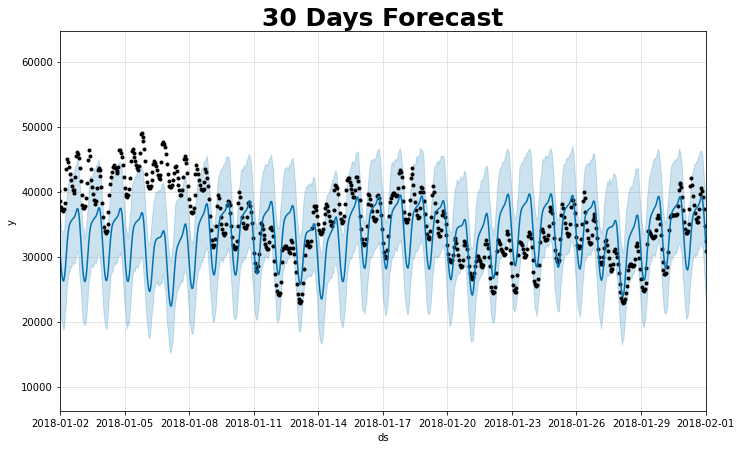

In [205]:
future_dates2 = prophet_model2.make_future_dataframe(periods=720, freq='H')
prophet_pred3 = prophet_model2.predict(future_dates2)

plt.figure(figsize=(20,8))

fig = prophet_model2.plot(prophet_pred3, uncertainty=True)
ax = fig.gca()
ax.set_xlim(pd.to_datetime(['2018-01-02', '2018-02-01']))
plt.title('30 Days Forecast', weight='bold', fontsize=25)
plt.show()

In [209]:
- 